# Power distribution in legislative chamber based on districting plan.

My goal is to compare the power distribution in the Virginia house of delegates in 2017 to the one that would have resulted if redistricting has occurred that year using MCMC. 

## Creating sample data: Fairfax City and County

I want to do some exploratory redistricting, but I need to work with a smaller data set. I'm going to use the fantastic 2017 shapefiles that includes population data and election results from MGGG. 

In [1]:
library(sf)
library(ggplot2)
library(tidyverse)
library(tibble)
library(magrittr)

# read in file
data_dir = "C:/Users/madie/OneDrive/data/" # the data's on onedrive b/c the files are getting too large
df_va <- st_read(paste(data_dir, "VA-2017/VA_precincts/VA_precincts.shp", sep=""))

# separate out precincts in Fairfax County/city
df_ff <- df_va[df_va$locality %in% c("Fairfax County", "Fairfax City"),]

# add in unique ID for each precinct
df_ff <- cbind(geoid10 = rownames(df_ff), df_ff)

# save this small set of 249 precincts to a separate shape file.
st_write(df_ff, paste(data_dir, "VA-2017/Fairfax_precincts/Fairfax_precincts.shp", sep=""), append=FALSE)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract




Reading layer `VA_precincts' from data source `C:\Users\madie\OneDrive\data\VA-2017\VA_precincts\VA_precincts.shp' using driver `ESRI Shapefile'
Simple feature collection with 2439 features and 56 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -373531.2 ymin: 60026.37 xmax: 380257.5 ymax: 385298.6
projected CRS:  Lambert_Conformal_Conic
Deleting layer `Fairfax_precincts' using driver `ESRI Shapefile'
Writing layer `Fairfax_precincts' to data source `C:/Users/madie/OneDrive/data/VA-2017/Fairfax_precincts/Fairfax_precincts.shp' using driver `ESRI Shapefile'
Writing 249 features with 57 fields and geometry type Multi Polygon.


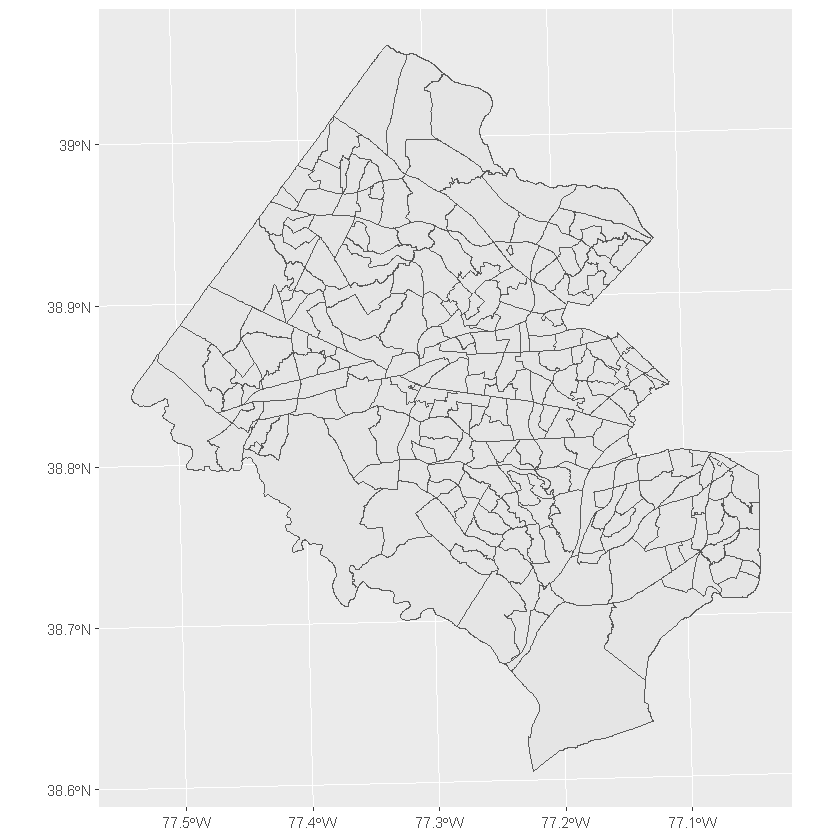

In [17]:
# plot the precincts!
ff_plot <- ggplot(data = df_ff) +
    geom_sf() #+
    #geom_sf_label(aes(label = geoid10))
ff_plot

## Reformat to meet MCMC requirements
MCMC has specific name requirements for cols, etc. I need to meet those. 

In [3]:
# copy over useful cols and rename them
precinct.data <- df_ff %>%
    select(geoid10 = geoid10,
           pop = TOTPOP,
           vap = VAP,
           obama = G17DHOD,
           mccain = G17RHOD,
           TotPop = TOTPOP,
           BlackPop = NH_BLACK,
           HispPop = HISP,
           VAP_1 = VAP,
           BlackVAP = BVAP,
           HispVAP = HVAP,
           geometry = geometry)
# change all cols to numeric type
precinct.data %<>% 
      mutate_each(funs(if(is.character(.)) as.numeric(.) else .))
head(precinct.data)

Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"`mutate_each_()` is deprecated as of dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


,geoid10,pop,vap,obama,mccain,TotPop,BlackPop,HispPop,VAP_1,BlackVAP,HispVAP,geometry
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
1,1580,1236,950,344,220,1236,35,57,950,24,41,MULTIPOLYGON (((201746.7 32...
2,1581,7218,6003,1451,0,7218,467,742,6003,367,573,MULTIPOLYGON (((199327.1 32...
3,1582,3016,2345,702,199,3016,63,1332,2345,42,988,MULTIPOLYGON (((201091.9 31...
4,1583,3395,2673,881,334,3395,201,930,2673,141,704,MULTIPOLYGON (((204934.1 31...
5,1584,3774,3050,761,372,3774,291,797,3050,218,582,MULTIPOLYGON (((199054.4 31...
6,1585,4239,3254,978,424,4239,481,769,3254,340,574,MULTIPOLYGON (((201483.1 31...


## Redistricting
Ok, now I can run through the fleet of redistricting methods enabled by `redist`.

In [4]:
library(redist)
library(sp)
library(spData)
library(spdep)
library(igraph)


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    as_data_frame


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




### Adjacency-based Redistricting

Here each precinct gets a vector of the other precincts that it's adjacent to, and there's limited constraints applied. 

In [5]:
adjlist <- poly2nb(pl = precinct.data, queen = FALSE)
# The C++ backend is more efficient if it's zero-indexed. 
for(i in 1:249){
  adjlist[[i]] <- adjlist[[i]]-1
}

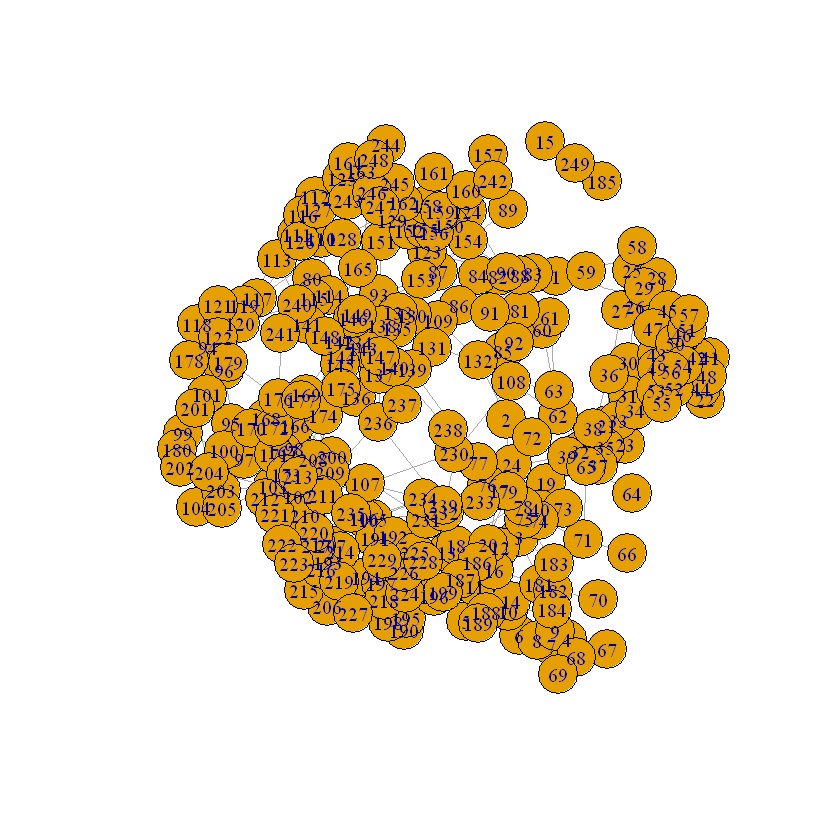

In [6]:
plot(graph_from_adj_list(adjlist, mode = 'total'))

### Single Chain

In [7]:
alg_mcmc <- redist.mcmc(adjobj = adjlist,
                        popvec = precinct.data$pop,
                        ndists = 10,
                        nsims = 10000)


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.960961

20 percent done.
Metropolis acceptance ratio: 0.95948

30 percent done.
Metropolis acceptance ratio: 0.954652

40 percent done.
Metropolis acceptance ratio: 0.955489

50 percent done.
Metropolis acceptance ratio: 0.955391

60 percent done.
Metropolis acceptance ratio: 0.954326

70 percent done.
Metropolis acceptance ratio: 0.951565

80 percent done.
Metropolis acceptance ratio: 0.952744

90 percent done.
Metropolis acceptance ratio: 0.952328

100 percent done.
Metropolis acceptance ratio: 0.951995



I love smaller data sets! This took ~50 seconds to run, compared to about 100 min for the full 2500 precincts.

In [8]:
# generate 10 random colors that are distinct so that the different districts are distinguishable. 
library(randomcoloR)
colors <- distinctColorPalette(k=15)

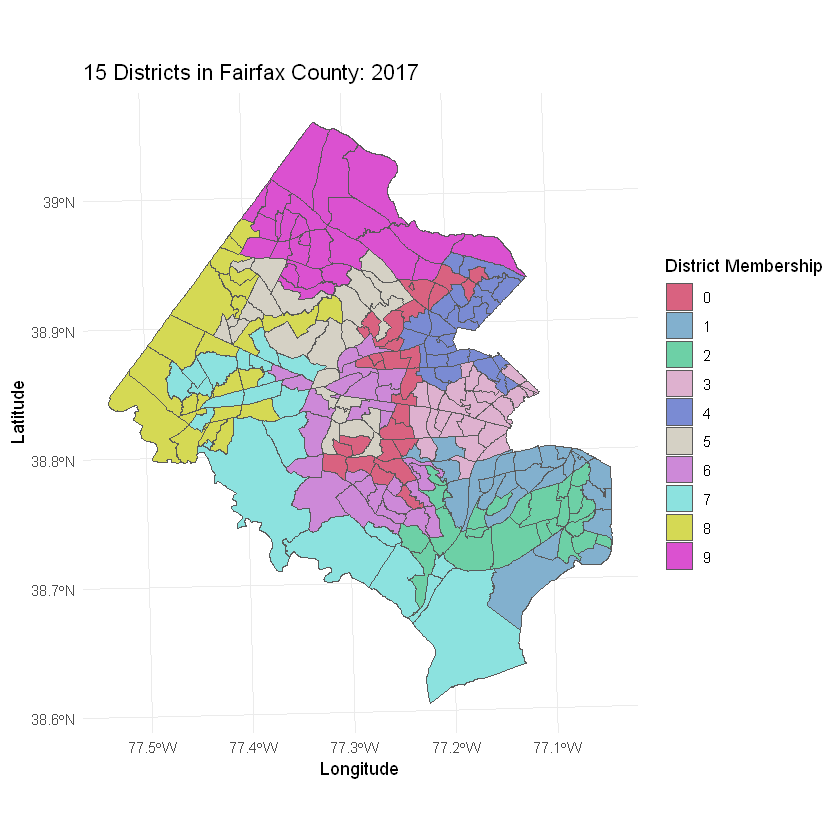

In [9]:
# Let's plot this!

cds <- alg_mcmc$partitions[,2]
plot <- redist.map(shp=precinct.data, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="15 Districts in Fairfax County: 2017") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))

plot

### 20% Population Constraint and Compactness Constraint

So that worked, but there are clearly some compactness problems going on here. 

I first need to calculate a `distancemat`, which is "a symmetric matrix with the squared distance between two precincts as its entries."

In [16]:
distances <- redist.distances(district_membership = cds,
                              measure = "Hamming",
                              ncores = 1

ERROR: Error in 1:ncol(district_membership): argument of length 0


In [12]:
## ----------------------------------------------------------
## Constrain on population and compactness with tempering,
## weight on population = 5.4 while weight on compactness = 3
## Also specifying argument for ssdmat, the distance matrix
## ----------------------------------------------------------
mcmc.out.st.multiple <- redist.mcmc(adjobj = adjlist,
                                    popvec = precinct.data$pop,
                                    ndists = 10,
                                    nsims = 10000,
                                    constraint = c("population", "compact"),
                                    constraintweights = c(5.4, 3),
                                    ssdmat = ,
                                    temper = TRUE,
                                    betaweights = betaweights,
                                    maxiterrsg = 10000)
mcmc.out.st <- redist.ipw(mcmc.out.st.multiple, targetpop = .2)


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.



ERROR: Error in redist.preproc(adjobj = adjobj, popvec = popvec, initcds = initcds, : object 'algdat.p20' not found
